# Descrição do projeto

Este projeto visa analisar o comportamento dos usuários de um aplicativo de uma startup que vende produtos alimentícios.

Primeiro, a respeito do funil de vendas: Como os usuários chegam à etapa de compra. 
Quantos usuários realmente chegam a essa etapa? Quantos ficam presos nas fases anteriores? Quais etapas em particular?

Em seguida, serão analisados os resultados do teste A/A/B: Os designers gostariam de alterar as fontes de todo o aplicativo, mas os gerentes temem que os usuários achem o novo design intimidador. Eles decidem tomar a decisão com base nos resultados de um teste A/A/B.

Os usuários são divididos em três grupos: dois grupos de controle recebem as fontes antigas e um grupo de teste recebe as novas. Descobriremos qual conjunto de fontes produz melhores resultados.

#### Importando as bibliotecas

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ydata_profiling import ProfileReport
import inflection
import seaborn as sns
from scipy import stats as st

# Definindo uma paleta padrão para os gráficos
my_palette = ['#768948', '#607744', '#34623f', '#34623f', '#1e2f23']
sns.set_palette(sns.color_palette(my_palette))

#### Importando a tabela

In [2]:
df_logs = pd.read_csv('logs_exp_us.csv', sep='\t')

#### Limpando os dados

In [3]:
# Gerando o data profiling report 
profile = ProfileReport(df_logs, title="Logs dataset", html={'style': {'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Através do reporte acima, podemos observar alguns ajustes importantes a serem realizados, como limpar dados duplicados, alterar tipos de dados verificar dados faltantes, renomear as colunas e criar colunas de data.

In [4]:
# Alterando os nomes das colunas para snake_case
df_logs = df_logs.rename(columns=lambda x: inflection.underscore(x))
df_logs.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [5]:
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
# Alterando os tipos de dados
df_logs['event_name'] = df_logs['event_name'].astype('category')
df_logs['exp_id'] = df_logs['exp_id'].astype('category')
df_logs['event_timestamp'] = pd.to_datetime(df_logs['event_timestamp'], unit='s')

In [7]:
# Removendo dados duplicados
df_logs.drop_duplicates(inplace=True)
df_logs.reset_index(drop=True, inplace=True)

In [8]:
df_logs['date'] = df_logs['event_timestamp'].dt.date
df_logs['date'] = pd.to_datetime(df_logs['date'])

In [9]:
# Tratando os dados faltantes
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  category      
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  category      
 4   date             243713 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1)
memory usage: 6.0 MB


#### Visualizando os dados

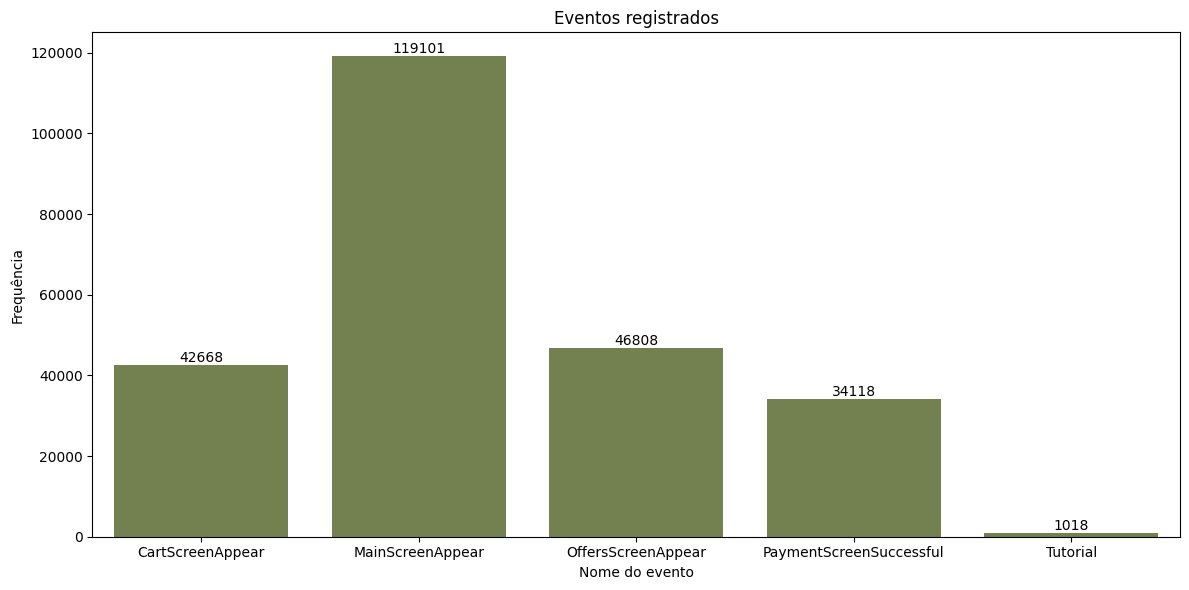

In [10]:
# Visualizando os eventos
events = df_logs['event_name'].value_counts()

# Plotando um histograma
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=events.index, y=events.values)

# Adicionando rótulos de contagem em cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')

# Adicionando as informações do gráfico
plt.title('Eventos registrados')
plt.xlabel('Nome do evento')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [11]:
# Usuários únicos
print('A quantidade de usuários únicos é: {}'.format(df_logs['device_id_hash'].nunique()))

A quantidade de usuários únicos é: 7551


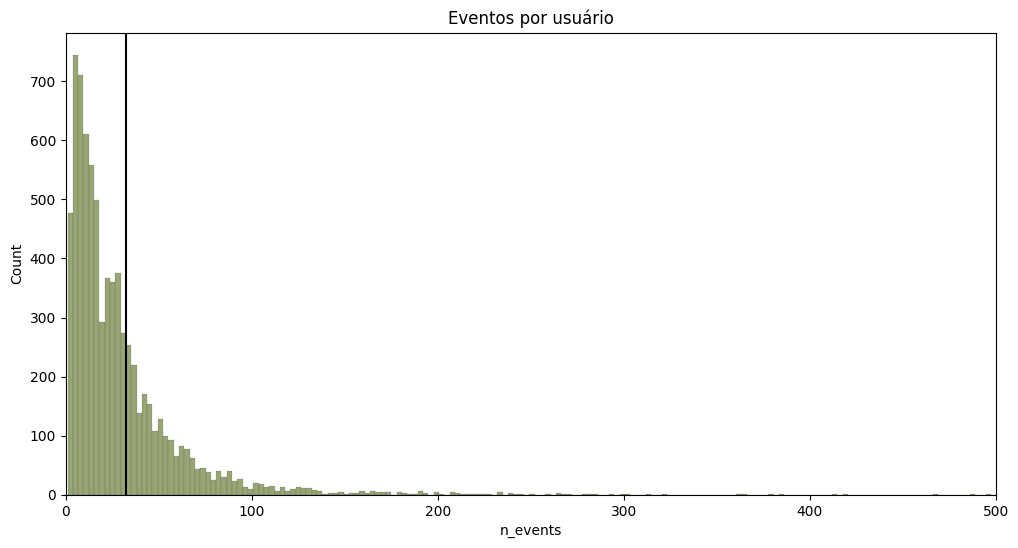

In [12]:
# Eventos por usuário
event_per_user = df_logs.groupby(['device_id_hash'], as_index=False)['event_name'].count().sort_values(by='event_name',ascending=False).rename(columns={'event_name':'n_events'})
plt.figure(figsize=(12,6))
sns.histplot(data=event_per_user, x='n_events')
plt.title('Eventos por usuário')
plt.xlim(0,500)
plt.axvline(event_per_user['n_events'].mean(), color='black')

In [13]:
# Printando a quantidade média de eventos por usuário
print('A quantidade média de eventos por usuário é: {:.2f}'.format(event_per_user['n_events'].mean()))

A quantidade média de eventos por usuário é: 32.28


#### Selecionando o período ideal

In [14]:
print('Data mais recente: {}'.format(df_logs['date'].max()))
print('Data mais antiga: {}'.format(df_logs['date'].min()))

Data mais recente: 2019-08-07 00:00:00
Data mais antiga: 2019-07-25 00:00:00


In [15]:
plt.figure(figsize=(12,6))
px.histogram(df_logs, 
             x='date', 
             color='exp_id',
             color_discrete_sequence=my_palette,
             title='Distribuição de usuários por dia',
             labels={
        'date': 'Data', 
        'exp_id': 'Grupo de Experimento'
    }
             )

c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\plotly\express\_core.py:1958: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers
c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])
c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an nda

<Figure size 1200x600 with 0 Axes>

In [16]:
# Agrupando por dia
lineplot = df_logs.groupby(['date','exp_id'], as_index=False, observed=True)[['device_id_hash']].count()

# Plotando a quantidade de usuários por dia e por grupo
fig = px.line(
    lineplot, 
    x='date', 
    y='device_id_hash', 
    color='exp_id', 
    title='Quantidade de Usuários por Dia e por Grupo', 
    labels={
        'date': 'Data', 
        'device_id_hash': 'Quantidade de Usuários', 
        'exp_id': 'Grupo de Experimento'
    },
    line_shape='linear',
    color_discrete_sequence=my_palette
)

# Ajustando a espessura das linhas
for trace in fig.data:
    trace.line.width = 3  # ajusta a espessura das linhas para 3

# Exibindo o gráfico
fig.show()

c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\plotly\express\_core.py:1958: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\joaoq\anaconda3\envs\myenv\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Com os gráficos acima, fica claro que os dados foram melhor preenchidos a partir do dia primeiro de agosto, e vamos trabalhar com os dados a partir dessa data a partir de agora. A seguir, vamos filtrar os dados e reavaliar alguns dados vistos recentemente.

In [17]:
# Filtrando os dados
df_logs_filtered = df_logs[df_logs['date'] >= '2019-08-01'].reset_index(drop=True)
df_logs_filtered

event_name       device_id_hash     event_timestamp exp_id  \
0                 Tutorial  3737462046622621720 2019-08-01 00:07:28    246   
1         MainScreenAppear  3737462046622621720 2019-08-01 00:08:00    246   
2         MainScreenAppear  3737462046622621720 2019-08-01 00:08:55    246   
3       OffersScreenAppear  3737462046622621720 2019-08-01 00:08:58    246   
4         MainScreenAppear  1433840883824088890 2019-08-01 00:08:59    247   
...                    ...                  ...                 ...    ...   
240882    MainScreenAppear  4599628364049201812 2019-08-07 21:12:25    247   
240883    MainScreenAppear  5849806612437486590 2019-08-07 21:13:59    246   
240884    MainScreenAppear  5746969938801999050 2019-08-07 21:14:43    246   
240885    MainScreenAppear  5746969938801999050 2019-08-07 21:14:58    246   
240886  OffersScreenAppear  5746969938801999050 2019-08-07 21:15:17    246   

             date  
0      2019-08-01  
1      2019-08-01  
2      2019-08-01  
3      2019-08-01  
4      2019-08-01  
...           ...  
240882 2019-08-07  
240883 2019-08-07  
240884 2019-08-07  
240885 2019-08-07  
240886 2019-08-07  

[240887 rows x 5 columns]

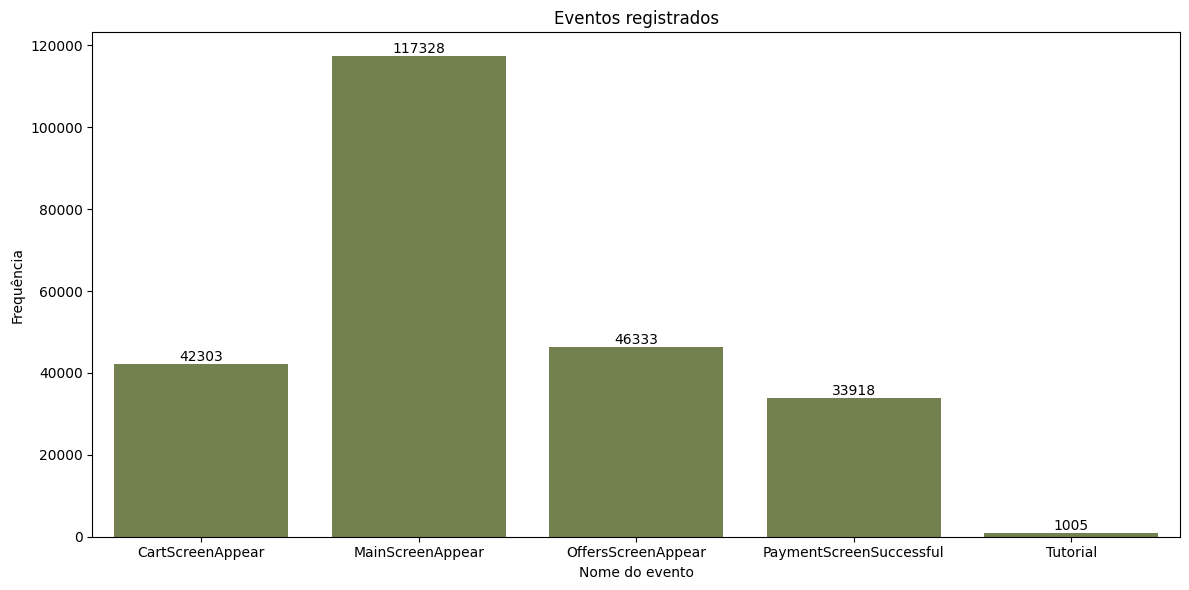

In [18]:
# Visualizando os eventos
events_filtered = df_logs_filtered['event_name'].value_counts()

# Plotando um histograma
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=events_filtered.index, y=events_filtered.values)

# Adicionando rótulos de contagem em cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')
    
# Ajustando o layout
plt.title('Eventos registrados')
plt.xlabel('Nome do evento')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

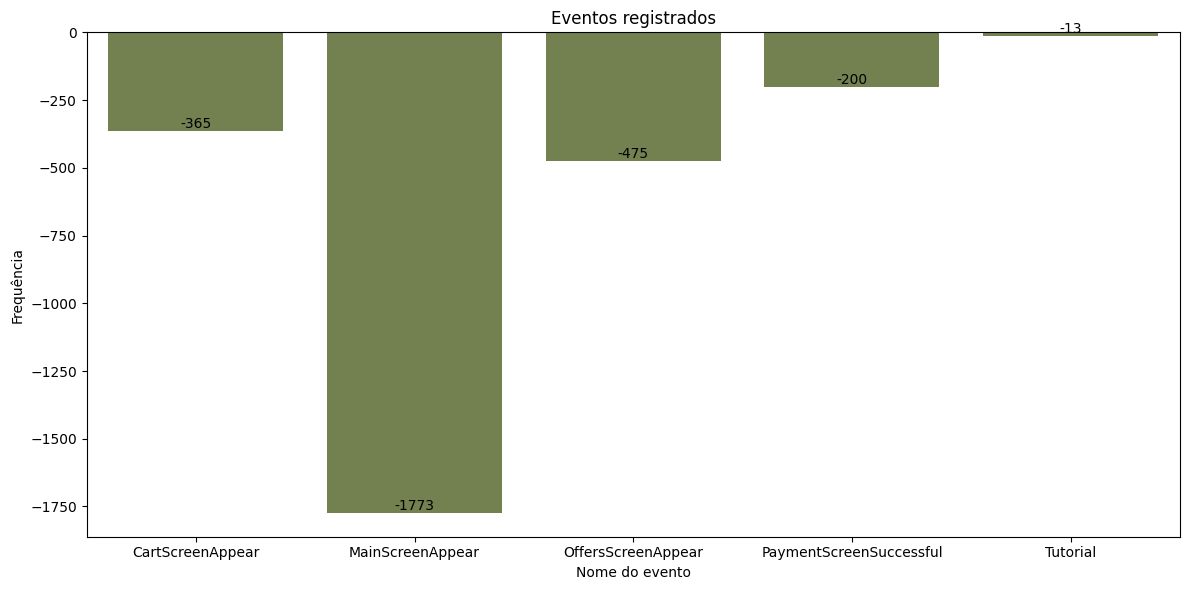

In [19]:
# Calculando a perda de usuários
events_merged = pd.concat([events, events_filtered], axis=1)
events_merged.columns = ['before_filter','after_filter']
events_merged['diff'] = events_merged['after_filter'] - events_merged['before_filter']

# Plotando um gráfico da diferença
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=events_merged.index, y=events_merged['diff'])

# Adicionando rótulos de contagem em cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')
    
# Ajustando o layout
plt.title('Eventos registrados')
plt.xlabel('Nome do evento')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

Houveram perdas em todas as etapas do funil, mas foram proporcionais às quantidades iniciais de cada evento, portanto não alteraram a ordem das quantidades de cada evento.

In [20]:
df_logs_filtered.groupby('exp_id', observed=False)['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

No final desta etapa, verificamos a quantidade de usuários restantes de cada grupo do experimento, vemos que ainda existem quantidades significativas de usuários nos três grupos, então podemos seguir com as análises. Agora, vamos analisar o funil de vendas e suas etapas.

#### Analisando o funil de vendas

In [21]:
# Visualizando as frequências dos eventos
print(f"""
Quantidade de eventos: {len(df_logs_filtered)}
Eventos por tipo: {df_logs_filtered.groupby("event_name", observed=True)["device_id_hash"]
                   .count()
                   .sort_values(ascending=False)}  

Usuários por evento: {df_logs_filtered.groupby("event_name", observed=True)["device_id_hash"]
                      .nunique()
                      .sort_values(ascending=False)}  

Proporção de usuários em cada evento: {(df_logs_filtered.groupby("event_name", observed=True)["device_id_hash"].nunique() / 
                                        df_logs_filtered["device_id_hash"].nunique()).sort_values(ascending=False)}
""")


Quantidade de eventos: 240887
Eventos por tipo: event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id_hash, dtype: int64  

Usuários por evento: event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64  

Proporção de usuários em cada evento: event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: device_id_hash, dtype: float64



Avaliando os eventos e suas ocorrências, podemos identificar que a ordem ocorre da seguinte maneira:  
1 - MainScreenAppear           
2 - OffersScreenAppear         
3 - CartScreenAppear           
4 - PaymentScreenSuccessful    

O evento de tutorial me parece ser opcional e poucos usuários passam por esta etapa.

In [22]:
# Removendo o evento opcional
new_events = df_logs_filtered[df_logs_filtered['event_name'] != 'Tutorial'].reset_index(drop=True)

In [23]:
new_events['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                        0
Name: count, dtype: int64

In [24]:
# Criando o df da análise dos eventos
users_by_event = new_events.groupby("event_name",observed=False)["device_id_hash"].nunique().sort_values(ascending=False).reset_index()

# Criando a coluna do evento anterior
users_by_event["users_in_previous_step"] = users_by_event["device_id_hash"].shift(1)

# Calculando a porcentagem de retenção
users_by_event["conversion_previous_step"] = users_by_event["device_id_hash"] / users_by_event["users_in_previous_step"]

# Calculando a porcentagem dos que saíram
users_by_event["dropoff_rate"] = 1 - users_by_event["conversion_previous_step"]

users_by_event.head()

event_name  device_id_hash  users_in_previous_step  \
0         MainScreenAppear            7419                     NaN   
1       OffersScreenAppear            4593                  7419.0   
2         CartScreenAppear            3734                  4593.0   
3  PaymentScreenSuccessful            3539                  3734.0   
4                 Tutorial               0                  3539.0   

   conversion_previous_step  dropoff_rate  
0                       NaN           NaN  
1                  0.619086      0.380914  
2                  0.812976      0.187024  
3                  0.947777      0.052223  
4                  0.000000      1.000000

In [25]:
# Criando o gráfico de funil
fig = go.Figure(go.Funnel(
    y = users_by_event['event_name'],
    x = users_by_event['device_id_hash'],
    textinfo = "value+percent initial",
    marker = {"color": my_palette}
))

# Ajustando o título e exibindo o gráfico
fig.update_layout(title="Funil de Vendas")
fig.show()

A partir do funil criado acima, vemos que em uma visão geral, 48% dos usuários que aparecem na primeira etapa chegaram até a última. Além disso, é observado uma perda de 38% de usuários entre a primeira etapa e a segunda, está é a fase que mais perdemos usuários.

#### Experimentação - Teste A/A/B

In [26]:
# Calculando os usuários por grupo
df_logs_filtered.groupby('exp_id',observed=False)['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Primeiro, vamos analisar se a proporção de conversões entre os dois grupos de controle são significativamente iguais:

Para realizar o teste, vamos utilizar o teste de proporções Z-teste. Essa escolha foi feita pois vamos analisar especificamente a proporção de conversões entre os dois grupos e analisar se existe alguma diferença estatisticamente significativa, essa análise da proporção faz parte de uma análise da confiabilidade do experimento.

In [27]:
# Criando uma coluna para cada linha de id de usuário e grupo de experimento
convertions = df_logs_filtered[['device_id_hash','exp_id']].drop_duplicates()

# Criando uma coluna para os usuários que geraram conversão
converted = pd.DataFrame(
    data={'device_id_hash':
          df_logs_filtered[df_logs_filtered['event_name']=='PaymentScreenSuccessful']['device_id_hash'].unique(),
          'converted':1}
          )

# Mesclando as tabelas
convertions = convertions.merge(converted, on='device_id_hash', how='left')
convertions['converted'] = convertions['converted'].fillna(0).astype('int64')

convertions

device_id_hash exp_id  converted
0     3737462046622621720    246          1
1     1433840883824088890    247          0
2     4899590676214355127    247          1
3     1182179323890311443    246          0
4     4613461174774205834    248          1
...                   ...    ...        ...
7529  5811573131275421338    248          0
7530  5365227480683749189    248          0
7531  6660805781687343085    246          0
7532  7823752606740475984    246          1
7533  3454683894921357834    247          0

[7534 rows x 3 columns]

In [28]:
# Definindo as variáveis
p1 = convertions[convertions['exp_id'] ==246]['converted'].mean()
p2 = convertions[convertions['exp_id'] ==247]['converted'].mean()
p = convertions[np.logical_or(convertions['exp_id'] ==246, convertions['exp_id'] ==247)]["converted"].mean()
n1 = len(convertions[convertions["exp_id"] == 246])
n2 = len(convertions[convertions["exp_id"] == 247])
print(p1,p2)

# Calculando as estatísticas
statistic = (p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))

# Print da estatística calculada
print("Estatística z:", statistic)

0.4830917874396135 0.46080382013529647
Estatística z: 1.5779948491596598


In [29]:
# Calculando o p-valor
p_value = 2 * (1 - st.norm.cdf(abs(statistic)))

# Definindo o nível de significância (por exemplo, 0.05 para 5%)
alpha = 0.05

# Imprimindo os resultados
print(f'Estatística z: {statistic}')
print(f'p-valor: {p_value}')

# Verificando se a diferença é estatisticamente significativa
if p_value < alpha:
    print('A diferença é estatisticamente significativa.')
else:
    print('A diferença não é estatisticamente significativa.')

Estatística z: 1.5779948491596598
p-valor: 0.11456679313141849
A diferença não é estatisticamente significativa.


No teste de hipóteses, optamos pelo teste de distribuição normal ao invés do teste t de Student pois a população é grande o bastante para assumirmos - com base no teorema central do limite - que a variância da amostra é aproximada da variância populacional.

Definindo como a hipótese nula, de que os dois grupos não são significativamente diferentes, e a hipótese alternativa de que as amostras são significativamente diferentes, pudemos notar que a hipótese nula não pode ser rejeitada em relação a proporção de conversões em relação ao tamanho de cada grupo.

Agora, vamos aplicar o mesmo teste para todas as etapas:

In [30]:
# Criando uma função para retornar as estatísticas
def z_test(p1, p2, p, n1, n2, alpha):
    # Calculando as estatísticas
    statistic = (p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))
    
    # Calculando o p-valor
    p_value = 2 * (1 - st.norm.cdf(abs(statistic)))

    # Imprimindo os resultados
    print(f'Estatística z: {statistic}')
    print(f'p-valor: {p_value}')
    print(f'alpha= 0.05')

    # Verificando se a diferença é estatisticamente significativa
    if p_value < alpha:
        return print('A diferença é estatisticamente significativa.')
    else:
        return print('A diferença não é estatisticamente significativa.')

In [31]:
# Criando as colunas para cada uma das etapas do funil
OffersScreenAppear = pd.DataFrame(
    data={'device_id_hash':df_logs_filtered[df_logs_filtered['event_name']=='OffersScreenAppear']['device_id_hash'].unique(),
          'offersscreenappear':1})

CartScreenAppear = pd.DataFrame(
    data={'device_id_hash':df_logs_filtered[df_logs_filtered['event_name']=='CartScreenAppear']['device_id_hash'].unique(),
          'cartscreenappear':1})  
 
# Adicionando no dataframe
convertions = convertions.merge(OffersScreenAppear, on='device_id_hash', how='left')
convertions['offersscreenappear'] = convertions['offersscreenappear'].fillna(0).astype('int64')

convertions = convertions.merge(CartScreenAppear, on='device_id_hash', how='left')
convertions['cartscreenappear'] = convertions['cartscreenappear'].fillna(0).astype('int64')
convertions

device_id_hash exp_id  converted  offersscreenappear  \
0     3737462046622621720    246          1                   1   
1     1433840883824088890    247          0                   0   
2     4899590676214355127    247          1                   1   
3     1182179323890311443    246          0                   0   
4     4613461174774205834    248          1                   1   
...                   ...    ...        ...                 ...   
7529  5811573131275421338    248          0                   0   
7530  5365227480683749189    248          0                   0   
7531  6660805781687343085    246          0                   0   
7532  7823752606740475984    246          1                   1   
7533  3454683894921357834    247          0                   0   

      cartscreenappear  
0                    1  
1                    0  
2                    1  
3                    0  
4                    1  
...                ...  
7529                 0  
7530                 0  
7531                 0  
7532                 1  
7533                 1  

[7534 rows x 5 columns]

##### Aplicando o Teste AA

In [32]:
# Criando uma lista dos eventos
events = ['offersscreenappear', 'cartscreenappear', 'converted']

# Printando os resultados do teste para cada evento
print('Rodando o teste A/A')
for event in events:
    p1 = convertions[convertions['exp_id'] ==246][event].mean()
    p2 = convertions[convertions['exp_id'] ==247][event].mean()
    p = convertions[np.logical_or(convertions['exp_id'] ==246, convertions['exp_id'] ==247)][event].mean()
    n1 = len(convertions[convertions['exp_id'] == 246])
    n2 = len(convertions[convertions['exp_id'] == 247])
    print(f'Evento: {event}')
    print(f'p1: {p1}, p2: {p2}, n1: {n1}, n2: {n2}')
    z_test(p1, p2, p, n1, n2, alpha=0.05)
    print()

Rodando o teste A/A
Evento: offersscreenappear
p1: 0.6207729468599034, p2: 0.6048547552725826, n1: 2484, n2: 2513
Estatística z: 1.154987713610383
p-valor: 0.2480954578522181
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: cartscreenappear
p1: 0.5096618357487923, p2: 0.4926382809391166, n1: 2484, n2: 2513
Estatística z: 1.203368576486285
p-valor: 0.22883372237997213
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: converted
p1: 0.4830917874396135, p2: 0.46080382013529647, n1: 2484, n2: 2513
Estatística z: 1.5779948491596598
p-valor: 0.11456679313141849
alpha= 0.05
A diferença não é estatisticamente significativa.



Definindo a hipótese nula (H0) como sendo a hipótese de que não há diferenças estatisticamente significativas entre os grupos de controle, e a hipótese alternativa (H1) como a hipótese de que há diferença significativa, constatamos que os dois grupos de controle não possuem diferenças estatisticamente significativas em relação a proporção de conversões em cada etapa. Nos 3 testes o p-valor ficou acima da significância de 5%.

##### Aplicando os testes AB

Vamos analisar os dois grupos em relação ao grupo do experimento, ou seja, vamos comparar os resultados em relação a alteração na fonte dos aplicativos.

Neste ponto, também serão realizados os mesmos testes de hipótese, ou seja, será realizado o teste de proporções z-teste, utilizando um teste de normalidade para identiicar o p-valor. A explicação para esta escolha é a mesma: estamos avaliando duas proporções de dados categóricos binários (conversão ou não) - e não médias de variáveis contínuas, como seria o caso do t-teste - e grupos que podemos considerar grandes o suficente para calcular o p-valor pela distribuição normal (z) - ao invés de uma distibuição t-Student.

In [33]:
# Printando os resultados dos testes
print('Rodando o teste A/B')
print('Comparação: Grupo controle 246 x Grupo do experimento 248')

for event in events:
    p1 = convertions[convertions['exp_id'] ==246][event].mean()
    p2 = convertions[convertions['exp_id'] ==248][event].mean()
    p = convertions[np.logical_or(convertions['exp_id'] ==246, convertions['exp_id'] ==248)][event].mean()
    n1 = len(convertions[convertions['exp_id'] == 246])
    n2 = len(convertions[convertions['exp_id'] == 248])
    print(f'Evento: {event}')
    print(f'p1: {p1}, p2: {p2}, n1: {n1}, n2: {n2}')
    z_test(p1, p2, p, n1, n2, alpha=0.05)
    print()

Rodando o teste A/B
Comparação: Grupo controle 246 x Grupo do experimento 248
Evento: offersscreenappear
p1: 0.6207729468599034, p2: 0.6034686637761135, n1: 2484, n2: 2537
Estatística z: 1.2580821335711887
p-valor: 0.20836205402738917
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: cartscreenappear
p1: 0.5096618357487923, p2: 0.48482459597950334, n1: 2484, n2: 2537
Estatística z: 1.7598736474548398
p-valor: 0.07842923237520116
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: converted
p1: 0.4830917874396135, p2: 0.46551044540796216, n1: 2484, n2: 2537
Estatística z: 1.2473878277158326
p-valor: 0.2122553275697796
alpha= 0.05
A diferença não é estatisticamente significativa.



In [34]:
# Printando os resultados dos testes
print('Rodando o teste A/B')
print('Comparação: Grupo controle 247 x Grupo do experimento 248')

for event in events:
    p1 = convertions[convertions['exp_id'] ==247][event].mean()
    p2 = convertions[convertions['exp_id'] ==248][event].mean()
    p = convertions[np.logical_or(convertions['exp_id'] ==247, convertions['exp_id'] ==248)][event].mean()
    n1 = len(convertions[convertions['exp_id'] == 247])
    n2 = len(convertions[convertions['exp_id'] == 248])
    print(f'Evento: {event}')
    print(f'p1: {p1}, p2: {p2}, n1: {n1}, n2: {n2}')
    z_test(p1, p2, p, n1, n2, alpha=0.05)
    print()

Rodando o teste A/B
Comparação: Grupo controle 247 x Grupo do experimento 248
Evento: offersscreenappear
p1: 0.6048547552725826, p2: 0.6034686637761135, n1: 2513, n2: 2537
Estatística z: 0.1007086015299871
p-valor: 0.9197817830592261
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: cartscreenappear
p1: 0.4926382809391166, p2: 0.48482459597950334, n1: 2513, n2: 2537
Estatística z: 0.5554019078073092
p-valor: 0.5786197879539783
alpha= 0.05
A diferença não é estatisticamente significativa.

Evento: converted
p1: 0.46080382013529647, p2: 0.46551044540796216, n1: 2513, n2: 2537
Estatística z: -0.3353759529753951
p-valor: 0.7373415053803964
alpha= 0.05
A diferença não é estatisticamente significativa.



Definindo a hipótese nula (H0) como sendo a hipótese de que não há diferenças estatisticamente significativas entre os grupos de controle e o grupo teste, e a hipótese alternativa (H1) como a hipótese de que há diferença significativa, vemos que não é possível descartar a hipótese nula para nenhum dos eventos, levando em consideração a significância de 5%. 

Vamos avaliar agora a questão da significância utilizada:
Aqui, vamos aplicar o método False Discovery Rate (FDR) para fazer a correção do valor dos p-valores, isso deve ser feito pois ao realizar múltiplos testes de hipóteses, as probabilidades de erro crescem bastante, o que pode nos fazer cometer erros do tipo 1, ou seja, falso positivos.

##### Corrigindo os p_valores do teste AA (246-247)

In [35]:
pvalores = [0.2480954578522181, 0.22883372237997213, 0.11456679313141849]
alpha = 0.05

[x < alpha for x in st.false_discovery_control(pvalores)]

[False, False, False]

##### Corrigindo os p_valores do teste AB (246-248)

In [36]:
pvalores = [0.20836205402738917, 0.07842923237520116, 0.2122553275697796]
alpha = 0.05

[x < alpha for x in st.false_discovery_control(pvalores)]

[False, False, False]

##### Corrigindo os p_valores do teste AB (247-248)

In [37]:
pvalores = [0.9197817830592261, 0.5786197879539783, 0.7373415053803964]
alpha = 0.05

[x < alpha for x in st.false_discovery_control(pvalores)]

[False, False, False]

##### Conclusão geral do estudo

Após aplicar todos os testes, conforme explicado durante o projeto, e corrigindo todos os testes com base na FDR, vemos que os resultados não alteraram. Isso significa que a alteração da fonte não teve impacto significativo nos dados de conversão em nenhuma etapa do funil, mesmo comparando com os dois grupos de controle.